Liliana Hotsko, Varinat: 6

### Data preparation

In [51]:
import numpy as np
import pandas as pd
import matplotlib
from statsmodels.tsa.stattools import adfuller

import scipy.interpolate as sc
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
import warnings
warnings.filterwarnings("ignore", category=Warning, module='statsmodels')


In [52]:
REGIONS = [['JH', 'Johor', 'JH'],
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'],
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [53]:
production.head()

,index,Region,Year,Month,Production,Diff_production
0,0,JH,1998,1,118.359,0.000
1,1,JH,1998,2,147.988,0.000
2,2,JH,1998,3,145.514,29.629
3,3,JH,1998,4,154.638,-2.474
4,4,JH,1998,5,155.827,9.124


In [54]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [55]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']],
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')

        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp

        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        data.drop(['Rainfall'], axis=1, inplace=True)

        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)

        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [56]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)

In [57]:
DATA['Sarawak']

(            Sarawak_Month  Sarawak_Area_ma  Sarawak_Area_npa  \
 1999-01-01              1       228.000000        320.000000   
 1999-02-01              2       228.000000        320.000000   
 1999-03-01              3       228.000000        320.000000   
 1999-04-01              4       228.000000        320.000000   
 1999-05-01              5       228.000000        320.000000   
 ...                   ...              ...               ...   
 2017-05-01              5       598.736842        759.473684   
 2017-06-01              6       598.736842        759.473684   
 2017-07-01              7       598.736842        759.473684   
 2017-08-01              8       598.736842        759.473684   
 2017-09-01              9       598.736842        759.473684   
 
             Sarawak_Area_rpa  Sarawak_Area_ma_new  Sarawak_Time  \
 1999-01-01               2.0           110.923077            12   
 1999-02-01               2.0           110.923077            13   
 1999-03-01   

In [58]:
DATA['Sarawak'][0].index

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01',
               ...
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01'],
              dtype='datetime64[ns]', length=225, freq=None)

In [59]:
DATA['Sarawak'][0]

,Sarawak_Month,Sarawak_Area_ma,Sarawak_Area_npa,Sarawak_Area_rpa,Sarawak_Area_ma_new,Sarawak_Time,Sarawak_Rainfall_6,Sarawak_Rainfall_7,Sarawak_Rainfall_8,Sarawak_Rainfall_9,Sarawak_Rainfall_10,Sarawak_Rainfall_11,Sarawak_Rainfall_12,Sarawak_Production_6,Sarawak_Production_7,Sarawak_Production_8,Sarawak_Production_9,Sarawak_Production_10,Sarawak_Production_11,Sarawak_Production_12
1999-01-01,1,228.000000,320.000000,2.0,110.923077,12,239.990,289.280,196.42,261.26,170.31,101.78,253.59,29.241,24.321,23.252,21.720,19.716,19.734,19.311
1999-02-01,2,228.000000,320.000000,2.0,110.923077,13,378.520,239.990,289.28,196.42,261.26,170.31,101.78,32.202,29.241,24.321,23.252,21.720,19.716,19.734
1999-03-01,3,228.000000,320.000000,2.0,110.923077,14,317.690,378.520,239.99,289.28,196.42,261.26,170.31,33.587,32.202,29.241,24.321,23.252,21.720,19.716
1999-04-01,4,228.000000,320.000000,2.0,110.923077,15,340.980,317.690,378.52,239.99,289.28,196.42,261.26,32.504,33.587,32.202,29.241,24.321,23.252,21.720
1999-05-01,5,228.000000,320.000000,2.0,110.923077,16,429.220,340.980,317.69,378.52,239.99,289.28,196.42,28.751,32.504,33.587,32.202,29.241,24.321,23.252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-01,5,598.736842,759.473684,3.0,256.724291,232,356.420,294.920,237.38,200.55,251.18,225.68,241.12,320.989,350.773,367.147,374.257,344.585,311.060,266.808
2017-06-01,6,598.736842,759.473684,3.0,256.724291,233,274.180,356.420,294.92,237.38,200.55,251.18,225.68,315.163,320.989,350.773,367.147,374.257,344.585,311.060
2017-07-01,7,598.736842,759.473684,3.0,256.724291,234,332.500,274.180,356.42,294.92,237.38,200.55,251.18,295.472,315.163,320.989,350.773,367.147,374.257,344.585
2017-08-01,8,598.736842,759.473684,3.0,256.724291,235,376.574,332.500,274.18,356.42,294.92,237.38,200.55,274.848,295.472,315.163,320.989,350.773,367.147,374.257


In [60]:
DATA['Sarawak'][1]

1999-01-01     23.360
1999-02-01     25.803
1999-03-01     33.317
1999-04-01     40.118
1999-05-01     39.372
               ...   
2017-05-01    327.777
2017-06-01    325.285
2017-07-01    378.159
2017-08-01    392.429
2017-09-01    380.892
Name: Production, Length: 225, dtype: float64

In [61]:
def run_sequence_plot(ts, title):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.plot(ts, label="Original")
    plt.plot(rolling_mean, label = "Rolling Mean")
    plt.plot(rolling_std, label = "Rolling Standart deviation")
    plt.title(title)
    plt.legend()
    plt.show()

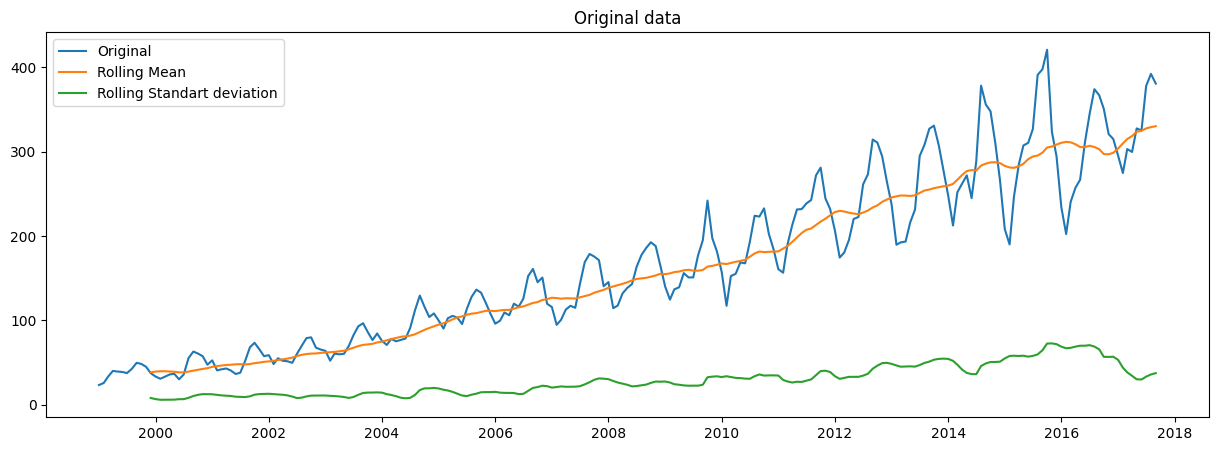

In [62]:
run_sequence_plot(DATA['Sarawak'][1], "Original data")

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [64]:
data = DATA['Sarawak'][1]

In [65]:
data

1999-01-01     23.360
1999-02-01     25.803
1999-03-01     33.317
1999-04-01     40.118
1999-05-01     39.372
               ...   
2017-05-01    327.777
2017-06-01    325.285
2017-07-01    378.159
2017-08-01    392.429
2017-09-01    380.892
Name: Production, Length: 225, dtype: float64

In [66]:
ss_decomposition_Additive = seasonal_decompose(x=data, model='additive', period=12)
estimated_trend_Additive = ss_decomposition_Additive.trend
estimated_seasonal_Additive = ss_decomposition_Additive.seasonal
estimated_residual_Additive = ss_decomposition_Additive.resid

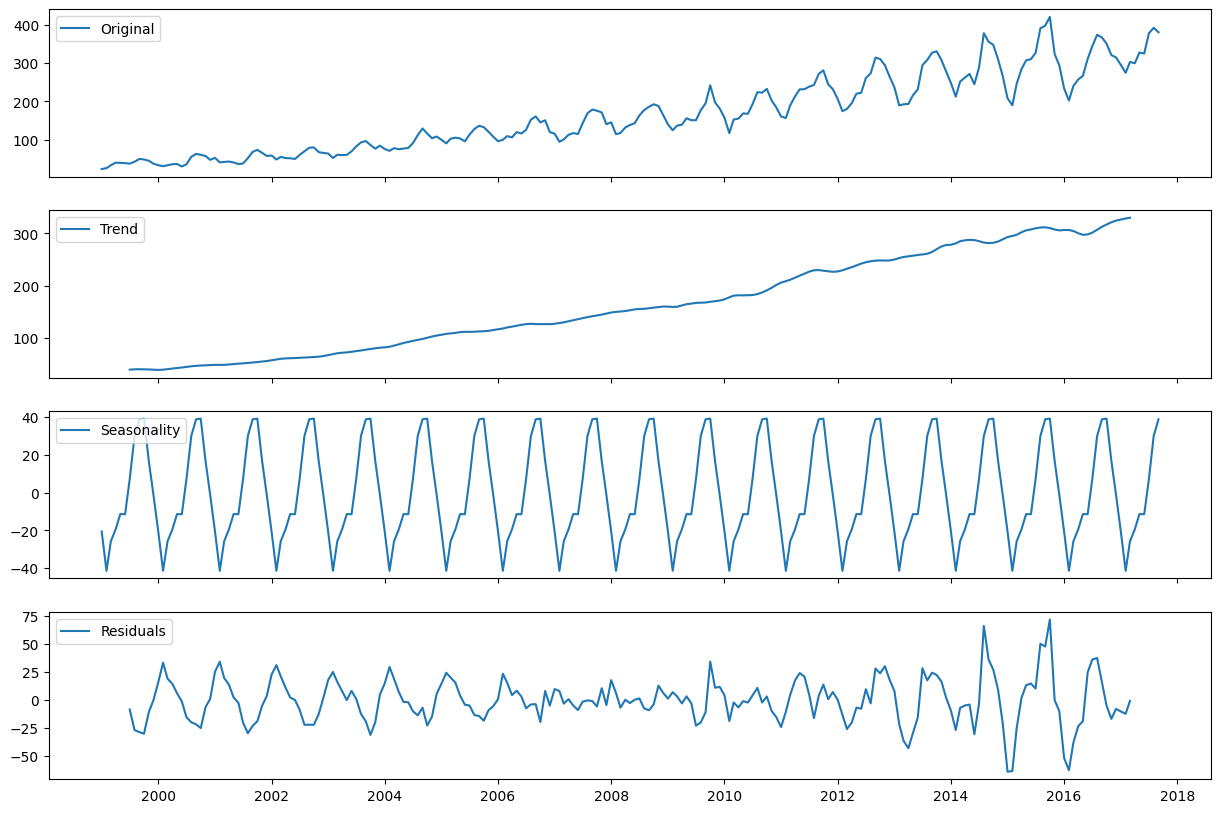

In [67]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend_Additive, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal_Additive, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual_Additive, label='Residuals')
axes[3].legend(loc='upper left')

residual_additive = estimated_residual_Additive

1)	Провести валідацію моделей типу SARIMA(X);

2)	Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). 

Інтегрувати екзогенні фактори, такі як опади, площі посівів і тп;

3)	Валідація фільтру Калмана*;

4)	Валідація додавання множників Фур’є в модель;

5)	Валідація Facebook Prophet;

6)	DL підходи (1dCNN, RNN, LSTM). Валідація гіперпараметрів*;

7)	Валідація моделей NBEATS, (temporal fusion transformer*);

8)	Висновки щодо того, яку модель краще використовувати; прогноз на наступний рік

### SARIMA(X)

SARIMA model expends on the ARIMA model by adding seasonal parameters.

 The validation process involved assessing model fit to historical data and evaluating their performance through metrics like Mean Squared Error (MSE).

m - frequency(number of observations per cycle)

our data was collected each month, so m=12

p - order of the seasonal AR(P) process
d - seasonal order of integration
q - order of the seasonal MA(q) process

In [19]:
ad_fuller_test = adfuller(data.dropna())
print('ADF Statistic: %f' % ad_fuller_test[0])
print('p-value: %f' % ad_fuller_test[1])


ADF Statistic: 1.062554
p-value: 0.994884


applying first-order differencing:

In [20]:
df_diff = np.diff(data, n=1)
ad_fuller_test = adfuller(df_diff)
print('ADF Statistic: %f' % ad_fuller_test[0])
print('p-value: %f' % ad_fuller_test[1])


ADF Statistic: -7.284620
p-value: 0.000000


so the first-order differencing gives us stationary data and we can work with it (we can now reject the null hypothesis so the series is considered to be stationary) d = 1


In [22]:
from itertools import product

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]
d = 1
D = 0
s = 12 # season length is still 12 and s is equal to m in sarima model notation
Arima_order_list = list(product(ps, qs, Ps, Qs))


In [24]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog, order_list: list, d: int, D: int, s: int):
    result = []
    print("yes")
    for order in order_list:
        try:
            model = SARIMAX(endog,
                            order=(order[0], d, order[1]),
                            seasonal_order=(order[2], D, order[3], s), 
                            simple_differencing=False).fit(disp=False)
            print(order)
        except:
            print("failed")
            continue
        aic = model.aic
        result.append([order, aic])
        
    result_df = pd.DataFrame(result)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df


train = data[:-12]
Arima_result_df = optimize_SARIMA(train, Arima_order_list, d, D, s)


yes
(0, 0, 0, 0)
(0, 1, 0, 0)
(0, 2, 0, 0)
(0, 3, 0, 0)
(0, 4, 0, 0)
(0, 5, 0, 0)
(0, 6, 0, 0)
(0, 7, 0, 0)
(0, 8, 0, 0)
(0, 9, 0, 0)
(0, 10, 0, 0)
(0, 11, 0, 0)
(0, 12, 0, 0)
(1, 0, 0, 0)
(1, 1, 0, 0)
(1, 2, 0, 0)
(1, 3, 0, 0)
(1, 4, 0, 0)
(1, 5, 0, 0)
(1, 6, 0, 0)
(1, 7, 0, 0)
(1, 8, 0, 0)
(1, 9, 0, 0)
(1, 10, 0, 0)
(1, 11, 0, 0)
(1, 12, 0, 0)
(2, 0, 0, 0)
(2, 1, 0, 0)
(2, 2, 0, 0)
(2, 3, 0, 0)
(2, 4, 0, 0)
(2, 5, 0, 0)
(2, 6, 0, 0)
(2, 7, 0, 0)
(2, 8, 0, 0)
(2, 9, 0, 0)
(2, 10, 0, 0)
(2, 11, 0, 0)
(2, 12, 0, 0)
(3, 0, 0, 0)
(3, 1, 0, 0)
(3, 2, 0, 0)
(3, 3, 0, 0)
(3, 4, 0, 0)
(3, 5, 0, 0)
(3, 6, 0, 0)
(3, 7, 0, 0)
(3, 8, 0, 0)
(3, 9, 0, 0)
(3, 10, 0, 0)
(3, 11, 0, 0)
(3, 12, 0, 0)
(4, 0, 0, 0)
(4, 1, 0, 0)
(4, 2, 0, 0)
(4, 3, 0, 0)
(4, 4, 0, 0)
(4, 5, 0, 0)
(4, 6, 0, 0)
(4, 7, 0, 0)
(4, 8, 0, 0)
(4, 9, 0, 0)
(4, 10, 0, 0)
(4, 11, 0, 0)
(4, 12, 0, 0)
(5, 0, 0, 0)
(5, 1, 0, 0)
(5, 2, 0, 0)
(5, 3, 0, 0)
(5, 4, 0, 0)
(5, 5, 0, 0)
(5, 6, 0, 0)
(5, 7, 0, 0)
(5, 8, 0, 0)
(5, 9, 0, 0)
(5, 10

In [25]:
Arima_result_df

,"(p, q, P, Q)",AIC
0,"(8, 10, 0, 0)",1728.269525
1,"(12, 6, 0, 0)",1728.967508
2,"(11, 12, 0, 0)",1729.802943
3,"(10, 12, 0, 0)",1730.097921
4,"(12, 7, 0, 0)",1730.498342
...,...,...
164,"(2, 0, 0, 0)",1895.002557
165,"(2, 1, 0, 0)",1895.171281
166,"(1, 1, 0, 0)",1895.302366
167,"(0, 1, 0, 0)",1898.390082


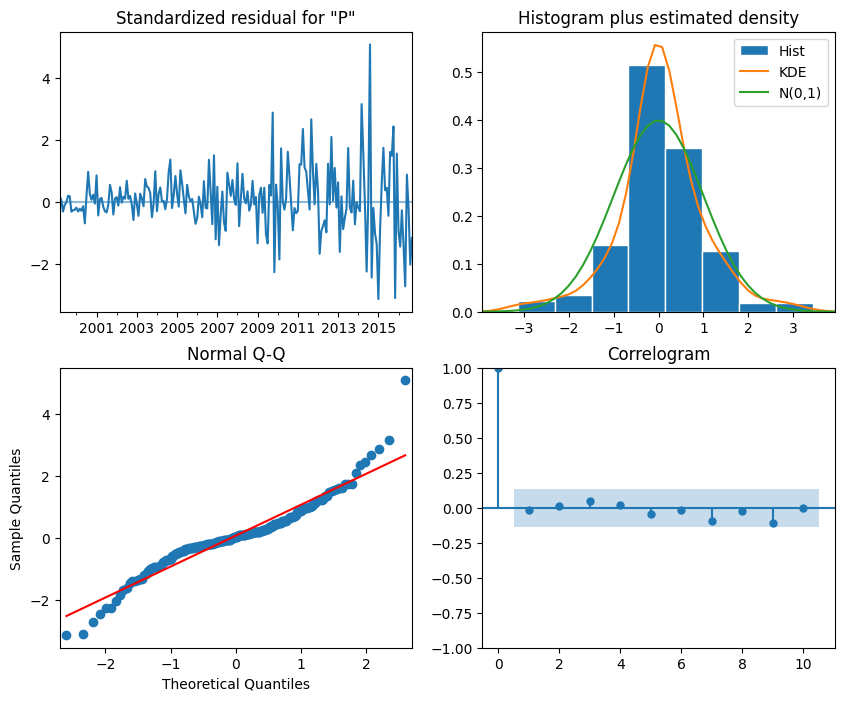

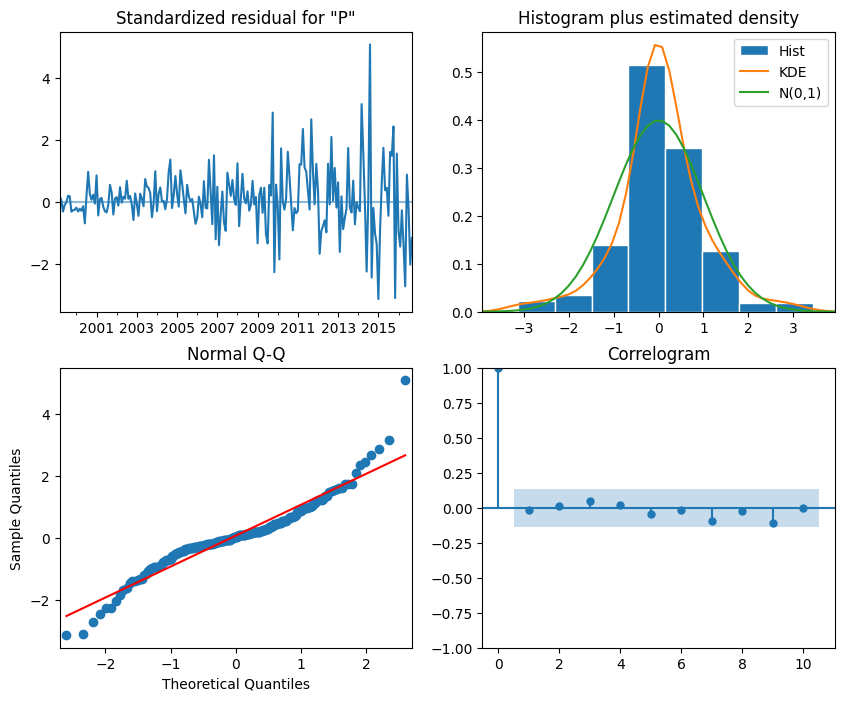

In [29]:
Arima_model = SARIMAX(train, order=(11, 2, 3), simple_differencing=False)
Arima_model_fit = Arima_model.fit(disp=False)
Arima_model_fit.plot_diagnostics(figsize=(10, 8))

In [34]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = Arima_model_fit.resid
# print(residuals)
lbvalues = acorr_ljungbox(residuals, np.arange(1, 213))
# print(lbvalues)
pvalues=lbvalues['lb_pvalue']
print(pvalues)


1      0.776816
2      0.937774
3      0.893778
4      0.955628
5      0.957882
         ...   
208    0.764488
209    0.776336
210    0.788259
211    0.750519
212    0.692858
Name: lb_pvalue, Length: 212, dtype: float64


In [45]:

from pandas import DataFrame as df
test = data.iloc[-12:]
test['naive_seasonal'] = data[-24:-12].values
ARIMA_pred = Arima_model_fit.get_prediction(213, 225).predicted_mean
print(ARIMA_pred)
test['ARIMA_pred'] = ARIMA_pred
print(test)


2016-10-01    393.007725
2016-11-01    338.480700
2016-12-01    309.726593
2017-01-01    260.102216
2017-02-01    238.178539
2017-03-01    251.931164
2017-04-01    265.297038
2017-05-01    291.652259
2017-06-01    327.674797
2017-07-01    355.767843
2017-08-01    386.565366
2017-09-01    384.115038
2017-10-01    396.146472
Freq: MS, Name: predicted_mean, dtype: float64
2016-10-01 00:00:00                                              350.773
2016-11-01 00:00:00                                              320.989
2016-12-01 00:00:00                                              315.163
2017-01-01 00:00:00                                              295.472
2017-02-01 00:00:00                                              274.848
2017-03-01 00:00:00                                              303.273
2017-04-01 00:00:00                                              299.824
2017-05-01 00:00:00                                              327.777
2017-06-01 00:00:00                         

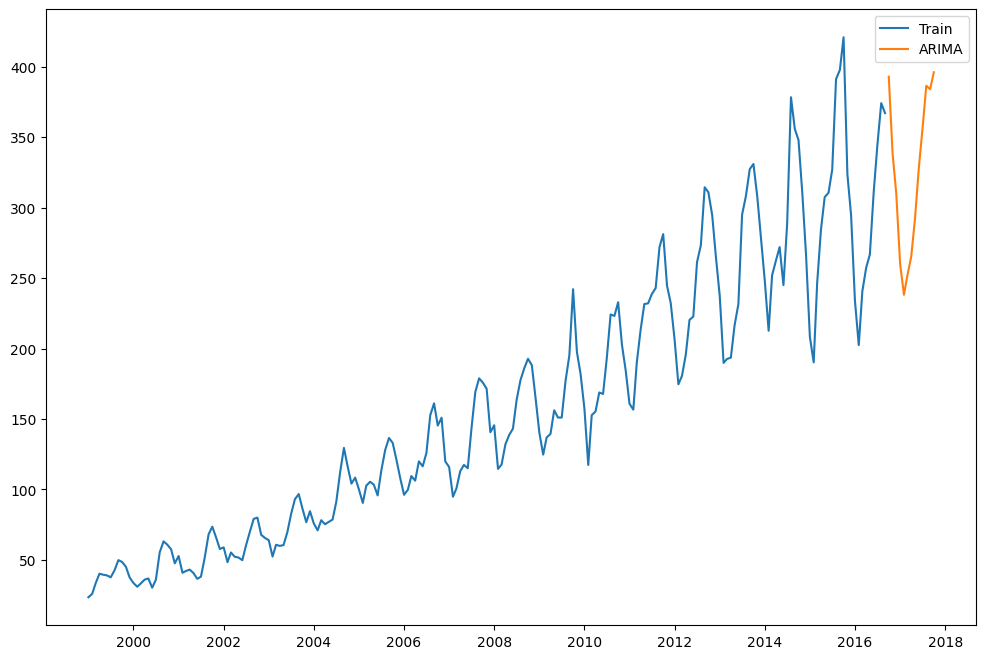

In [53]:
plt.figure(figsize=(12,8))
plt.plot(train, label='Train')
plt.plot(test['ARIMA_pred'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [71]:
data = DATA['Sarawak'][1]
ad_fuller_test = adfuller(data.dropna())
print('ADF Statistic: %f' % ad_fuller_test[0])
print('p-value: %f' % ad_fuller_test[1])

ADF Statistic: 1.062554
p-value: 0.994884


In [75]:
df_diff = np.diff(data, n=1)
ad_fuller_test = adfuller(df_diff)
print('ADF Statistic: %f' % ad_fuller_test[0])
print('p-value: %f' % ad_fuller_test[1])

ADF Statistic: -7.284620
p-value: 0.000000


In [76]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
train = data[:-12]
d = 1
D = 0
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df


yes
(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 2, 2)
(0, 0, 2, 3)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 3, 2)
(0, 0, 3, 3)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 2, 2)
(0, 1, 2, 3)
(0, 1, 3, 0)
(0, 1, 3, 1)
(0, 1, 3, 2)
(0, 1, 3, 3)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 2, 2, 2)
(0, 2, 2, 3)
(0, 2, 3, 0)
(0, 2, 3, 1)
(0, 2, 3, 2)
(0, 2, 3, 3)
(0, 3, 0, 0)
(0, 3, 0, 1)
(0, 3, 0, 2)
(0, 3, 0, 3)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 1, 2)
(0, 3, 1, 3)
(0, 3, 2, 0)
(0, 3, 2, 1)
(0, 3, 2, 2)
(0, 3, 2, 3)
(0, 3, 3, 0)
(0, 3, 3, 1)
(0, 3, 3, 2)
(0, 3, 3, 3)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 0, 2)
(1, 0, 0, 3)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 1, 2)
(1, 0, 1, 3)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 0, 2, 2)
(1, 0, 2, 3)
(1, 0, 3

,"(p, q, P, Q)",AIC
0,"(3, 2, 1, 2)",18.000000
1,"(2, 2, 3, 2)",1715.331071
2,"(3, 3, 3, 2)",1718.436201
3,"(2, 2, 3, 1)",1720.199752
4,"(2, 2, 1, 2)",1721.099744
...,...,...
251,"(2, 0, 0, 0)",1895.002557
252,"(2, 1, 0, 0)",1895.171281
253,"(1, 1, 0, 0)",1895.302366
254,"(0, 1, 0, 0)",1898.390082


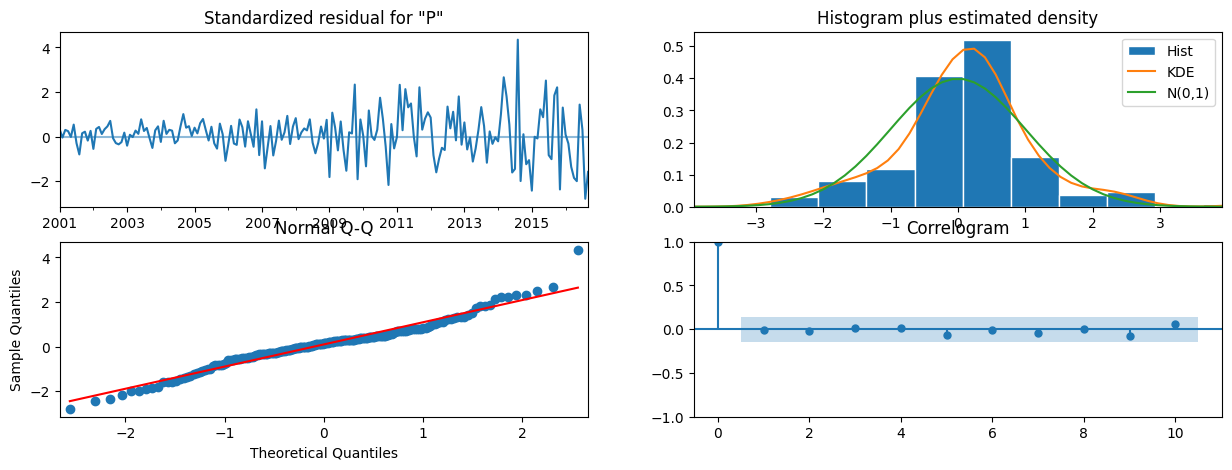

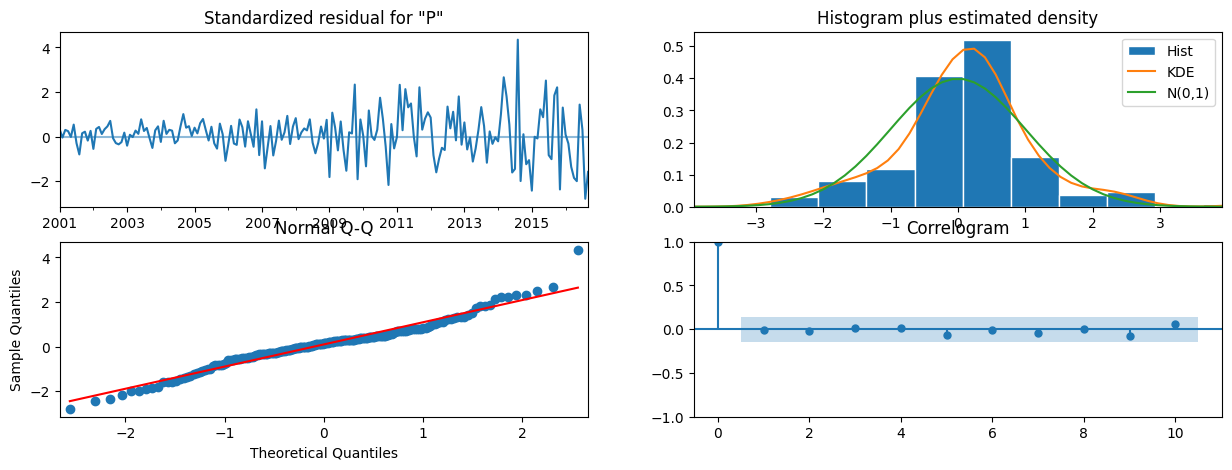

In [156]:
SARIMA_model = SARIMAX(train, order=(2, 0, 1), seasonal_order=(1, 2, 2, 12), simple_differencing=False)
SAIMA_model_fit = SARIMA_model.fit(disp=False)
SAIMA_model_fit.plot_diagnostics()


In [88]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SAIMA_model_fit.resid
lbvalues = acorr_ljungbox(residuals, np.arange(1, len(residuals)))  
print(lbvalues['lb_pvalue'])


1      2.723018e-05
2      1.903131e-07
3      4.387370e-09
4      1.065700e-09
5      2.413044e-09
           ...     
208    1.968874e-32
209    1.305720e-33
210    4.975835e-35
211    1.352851e-36
212    7.879251e-37
Name: lb_pvalue, Length: 212, dtype: float64


In [89]:
SARIMA_pred = SAIMA_model_fit.get_prediction(213, 225).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

In [115]:
print(data[-24:-12].values)

[421.    323.717 294.44  234.074 202.434 240.622 257.408 266.808 311.06
 344.585 374.257 367.147]


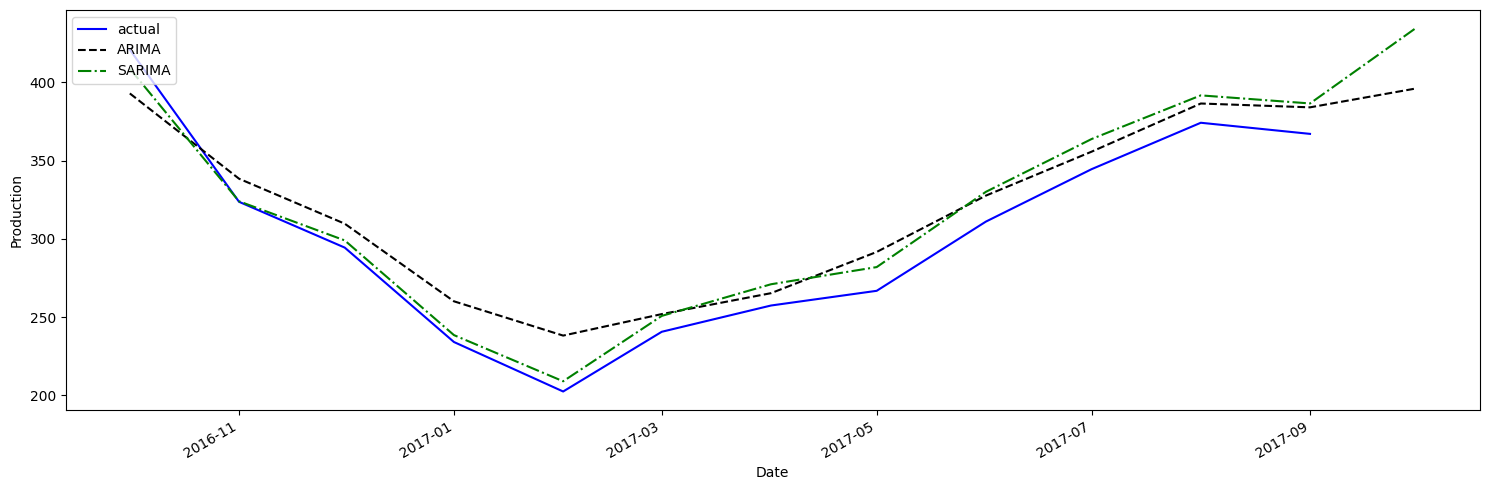

In [151]:
fig, ax = plt.subplots()
data2 = data[-24:-12]
data2.index = data[-12:].index
ax.plot(data2, 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Production')
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

### Генерація фіч та валідація ML моделей

### Iнтегрувати екзогенні фактори, такі як опади, площі посівів і тп;

Exogenous factors, such as precipitation and crop areas, were integrated as features. The validation process included training and testing these models using relevant evaluation metrics.

In [68]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']],
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')

        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp

        PRODUCTION = data.Production
        # data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        # data.drop(['Rainfall'], axis=1, inplace=True)

        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)

        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output




REGIONS = [['JH', 'Johor', 'JH'],
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'],
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)

In [69]:
data1 = DATA['Sarawak'][0].iloc[:, :7]
data1


,Sarawak_Month,Sarawak_Production,Sarawak_Rainfall,Sarawak_Area_ma,Sarawak_Area_npa,Sarawak_Area_rpa,Sarawak_Area_ma_new
1999-01-01,1,23.360,417.70,228.000000,320.000000,2.0,110.923077
1999-02-01,2,25.803,349.89,228.000000,320.000000,2.0,110.923077
1999-03-01,3,33.317,324.54,228.000000,320.000000,2.0,110.923077
1999-04-01,4,40.118,170.15,228.000000,320.000000,2.0,110.923077
1999-05-01,5,39.372,218.32,228.000000,320.000000,2.0,110.923077
...,...,...,...,...,...,...,...
2017-05-01,5,327.777,307.62,598.736842,759.473684,3.0,256.724291
2017-06-01,6,325.285,211.92,598.736842,759.473684,3.0,256.724291
2017-07-01,7,378.159,158.14,598.736842,759.473684,3.0,256.724291
2017-08-01,8,392.429,391.86,598.736842,759.473684,3.0,256.724291


In [70]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [71]:
data = data1
X = data.drop('Sarawak_Production', axis=1)
y = data['Sarawak_Production']
selector = SelectKBest(score_func=f_regression, k=3)  
X_selected = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)

selected_feature_names = X.columns[selected_feature_indices]
print(selected_feature_names)

Index(['Sarawak_Area_ma', 'Sarawak_Area_npa', 'Sarawak_Area_ma_new'], dtype='object')


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3562.052876796975


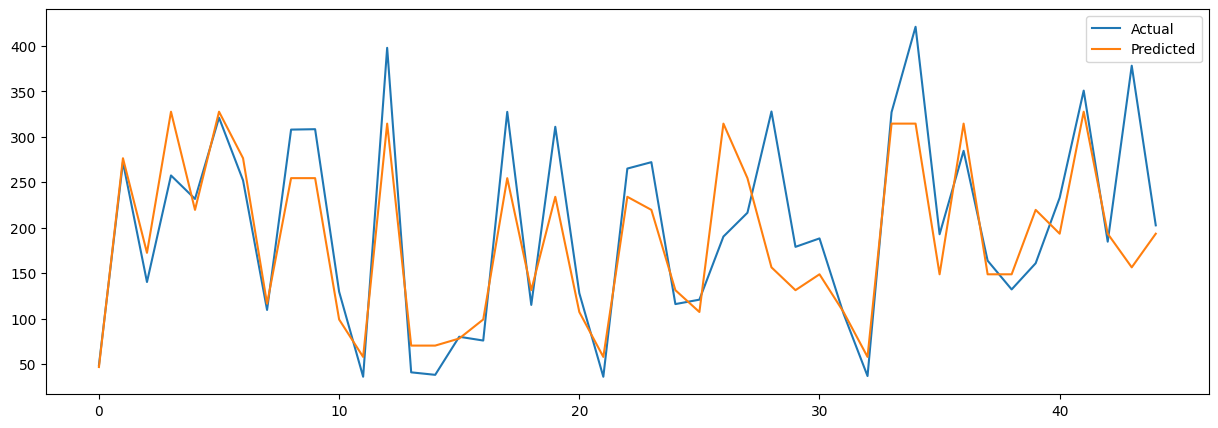

In [73]:
plt.plot(y_test.values, label='Actual') 
plt.plot(y_pred, label='Predicted')
plt.legend()

### plotting the features

In [74]:
type(data1)
csv_file = 'data_np.csv'

np.savetxt(csv_file, data1, delimiter=',')
df = pd.read_csv('data_np.csv')

In [104]:
df.columns = data1.columns
# df save to csv
df.to_csv('data_np1.csv', index=False)
# .savetxt('data_np1.csv', df, delimiter=',')

In [76]:
df

,Sarawak_Month,Sarawak_Production,Sarawak_Rainfall,Sarawak_Area_ma,Sarawak_Area_npa,Sarawak_Area_rpa,Sarawak_Area_ma_new
0,2.0,25.803,349.89,228.000000,320.000000,2.0,110.923077
1,3.0,33.317,324.54,228.000000,320.000000,2.0,110.923077
2,4.0,40.118,170.15,228.000000,320.000000,2.0,110.923077
3,5.0,39.372,218.32,228.000000,320.000000,2.0,110.923077
4,6.0,38.879,218.02,228.000000,320.000000,2.0,110.923077
...,...,...,...,...,...,...,...
219,5.0,327.777,307.62,598.736842,759.473684,3.0,256.724291
220,6.0,325.285,211.92,598.736842,759.473684,3.0,256.724291
221,7.0,378.159,158.14,598.736842,759.473684,3.0,256.724291
222,8.0,392.429,391.86,598.736842,759.473684,3.0,256.724291


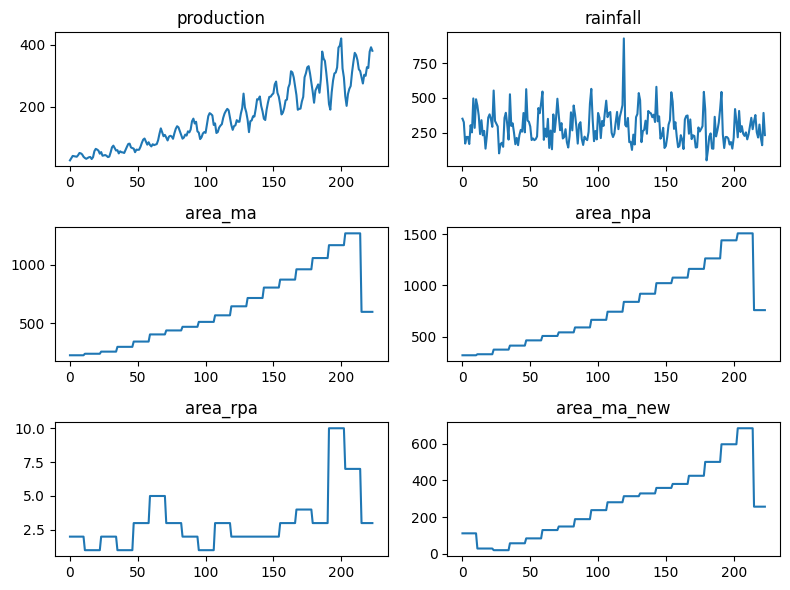

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))

axes[0, 0].plot(df['Sarawak_Production'])
axes[0, 0].set_title('production')

axes[0, 1].plot(df['Sarawak_Rainfall'])
axes[0, 1].set_title('rainfall')

axes[1, 0].plot(df['Sarawak_Area_ma'])
axes[1, 0].set_title('area_ma')

axes[1, 1].plot(df['Sarawak_Area_npa'])
axes[1, 1].set_title('area_npa')

axes[2, 0].plot(df['Sarawak_Area_rpa'])
axes[2, 0].set_title('area_rpa')

axes[2, 1].plot(df['Sarawak_Area_ma_new'])
axes[2, 1].set_title('area_ma_new')

plt.tight_layout()
plt.show()



### додавання множників Фур’є в модель

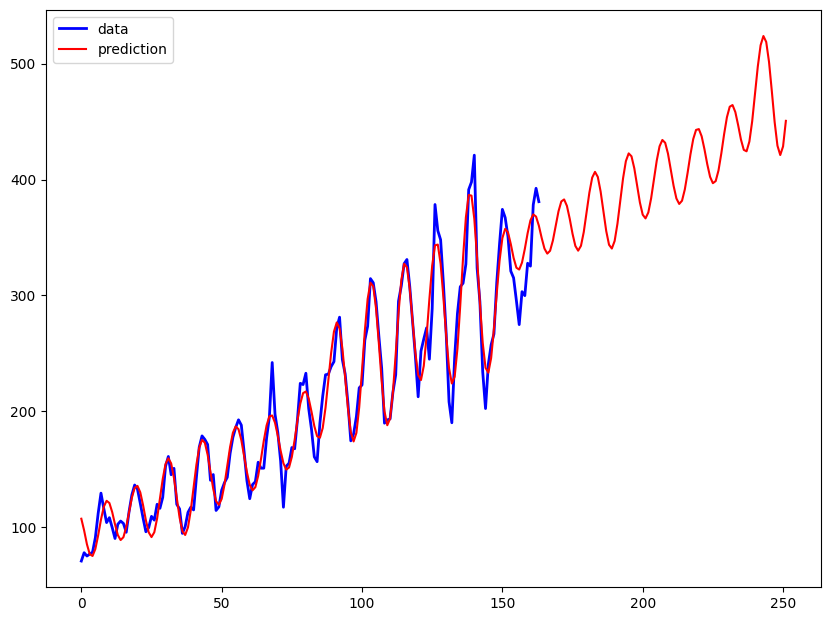

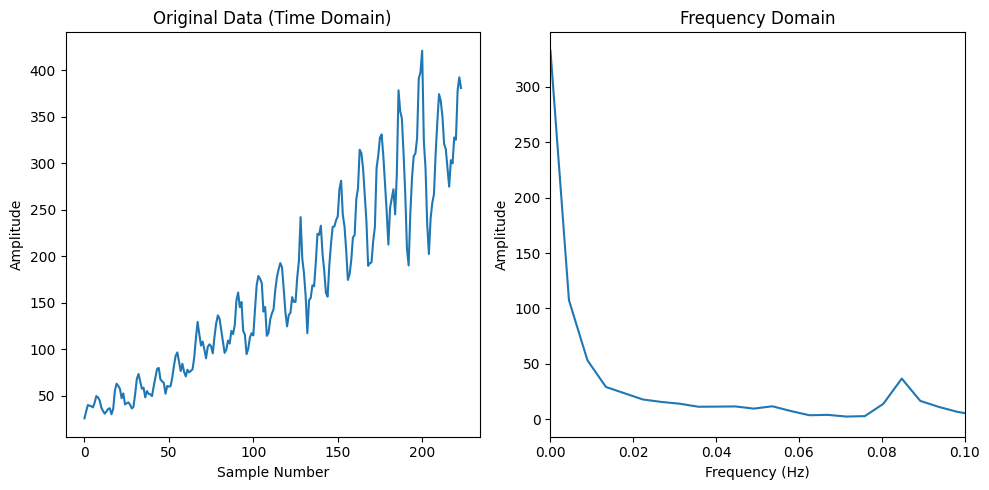

In [123]:
import numpy as np
import matplotlib.pyplot as plt

def fourierPredictionPlot(y, prediction):
    plt.plot(np.arange(0, y.size), y, 'b', label = 'data', linewidth = 2)
    plt.plot(np.arange(0, prediction.size), prediction, 'r', label = 'prediction')
    plt.legend()
    
def fourierPrediction(y, n_predict):
    n = y.size
    n_harm = 14
    t = np.arange(0, n)
    p = np.polyfit(t, y, 1)     
    y_notrend = y - p[0] * t          
    y_freqdom = np.fft.fft(y_notrend)
    f = np.fft.fftfreq(n)  
    indexes = list(range(n))
    indexes.sort(key = lambda i: np.absolute(f[i]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(y_freqdom[i]) / n  
        phase = np.angle(y_freqdom[i]) 
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

n_predict = 100
prediction = fourierPrediction(df['Sarawak_Production'][60:-12], n_predict)
fourierPredictionPlot(df['Sarawak_Production'][60:], prediction)


data = df['Sarawak_Production']
fft_result = np.fft.fft(data)
N = len(data)  # Length of the data
T = 1.0  # Sample spacing
frequencies = np.fft.fftfreq(N, T)[:N//2]  # Frequencies
amplitudes = 2.0/N * np.abs(fft_result[:N//2])  # Amplitudes

# Create a plot to visualize the frequency domain
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(data)
plt.title('Original Data (Time Domain)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(frequencies, amplitudes)
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.1)

plt.tight_layout()
plt.show()


In [125]:
df

,Sarawak_Month,Sarawak_Production,Sarawak_Rainfall,Sarawak_Area_ma,Sarawak_Area_npa,Sarawak_Area_rpa,Sarawak_Area_ma_new
0,2.0,25.803,349.89,228.000000,320.000000,2.0,110.923077
1,3.0,33.317,324.54,228.000000,320.000000,2.0,110.923077
2,4.0,40.118,170.15,228.000000,320.000000,2.0,110.923077
3,5.0,39.372,218.32,228.000000,320.000000,2.0,110.923077
4,6.0,38.879,218.02,228.000000,320.000000,2.0,110.923077
...,...,...,...,...,...,...,...
219,5.0,327.777,307.62,598.736842,759.473684,3.0,256.724291
220,6.0,325.285,211.92,598.736842,759.473684,3.0,256.724291
221,7.0,378.159,158.14,598.736842,759.473684,3.0,256.724291
222,8.0,392.429,391.86,598.736842,759.473684,3.0,256.724291


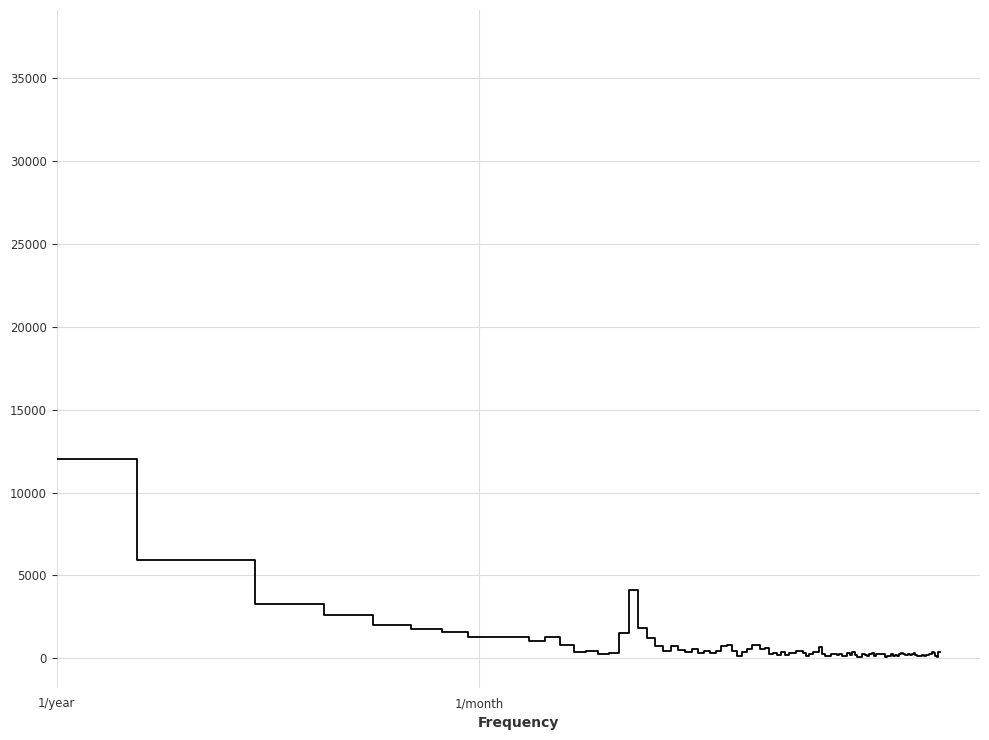

In [294]:
import tensorflow as tf
fft = tf.signal.rfft(df['Sarawak_Production'])
f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(df['Sarawak_Production'])
days_per_months = 12 * 30 
months_per_dataser = n_sample_h / days_per_months
f_per_week = f_per_dataset / months_per_dataser
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 12], ['1/year', '1/month'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [108]:
n = len(df['Sarawak_Production'])
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [110]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

train_df.to_csv('ch18_train.csv', index=False, header=True)
val_df.to_csv('ch18_val.csv', index=False, header=True)
test_df.to_csv('ch18_test.csv', index=False, header=True)

In [330]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
tf.random.set_seed(42)
np.random.seed(42)
train_df = pd.read_csv('ch18_train.csv')
val_df = pd.read_csv('ch18_val.csv')
test_df = pd.read_csv('ch18_test.csv')
column_indices = {name: i for i, name in enumerate(train_df.columns)}

{'Sarawak_Month': 0,
 'Sarawak_Production': 1,
 'Sarawak_Rainfall': 2,
 'Sarawak_Area_ma': 3,
 'Sarawak_Area_npa': 4,
 'Sarawak_Area_rpa': 5,
 'Sarawak_Area_ma_new': 6}

### Facebook Prophet


The model's flexibility and ability to capture various seasonal patterns were assessed, and its performance was evaluated using relevant metrics.

In [113]:
!pip install prophet


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [165]:
df['date_column'] = pd.date_range(start='1999-02-01', periods=len(df), freq='MS')
df.to_csv('df_yearly.csv', index=False)
df

,Sarawak_Month,Sarawak_Production,Sarawak_Rainfall,Sarawak_Area_ma,Sarawak_Area_npa,Sarawak_Area_rpa,Sarawak_Area_ma_new,indecies,date_column
0,0,25.803,349.89,228.000000,320.000000,2.0,110.923077,0,1999-02-01
1,1,33.317,324.54,228.000000,320.000000,2.0,110.923077,1,1999-03-01
2,2,40.118,170.15,228.000000,320.000000,2.0,110.923077,2,1999-04-01
3,3,39.372,218.32,228.000000,320.000000,2.0,110.923077,3,1999-05-01
4,4,38.879,218.02,228.000000,320.000000,2.0,110.923077,4,1999-06-01
...,...,...,...,...,...,...,...,...,...
219,219,327.777,307.62,598.736842,759.473684,3.0,256.724291,219,2017-05-01
220,220,325.285,211.92,598.736842,759.473684,3.0,256.724291,220,2017-06-01
221,221,378.159,158.14,598.736842,759.473684,3.0,256.724291,221,2017-07-01
222,222,392.429,391.86,598.736842,759.473684,3.0,256.724291,222,2017-08-01


In [139]:
data = df[['date_column', 'Sarawak_Production']]
data

data.columns = ['ds', 'y']
data

from prophet import Prophet
model = Prophet()

train = data[:-12]
test = data[-12:] 
train
model.fit(train)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat','yhat_lower', 'yhat_upper']]
test['baseline'] = train['y'][-12:].values
test

23:30:11 - cmdstanpy - INFO - Chain [1] start processing


23:30:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,y,yhat,yhat_lower,yhat_upper,baseline
212,2016-10-01,350.773,360.724275,332.837918,386.754700,421.000
213,2016-11-01,320.989,360.648699,334.602699,386.383023,323.717
214,2016-12-01,315.163,361.836780,336.067779,388.956397,294.440
215,2017-01-01,295.472,364.298034,338.529074,391.459901,234.074
216,2017-02-01,274.848,367.999329,340.632398,395.082340,202.434
217,2017-03-01,303.273,372.865189,346.208208,400.694842,240.622
218,2017-04-01,299.824,378.779398,351.395179,403.292415,257.408
219,2017-05-01,327.777,385.587875,359.370813,413.788665,266.808
220,2017-06-01,325.285,393.102720,365.041433,418.774616,311.060
221,2017-07-01,378.159,401.107329,374.214448,430.004377,344.585


In [140]:
from sklearn.metrics import mean_absolute_error
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

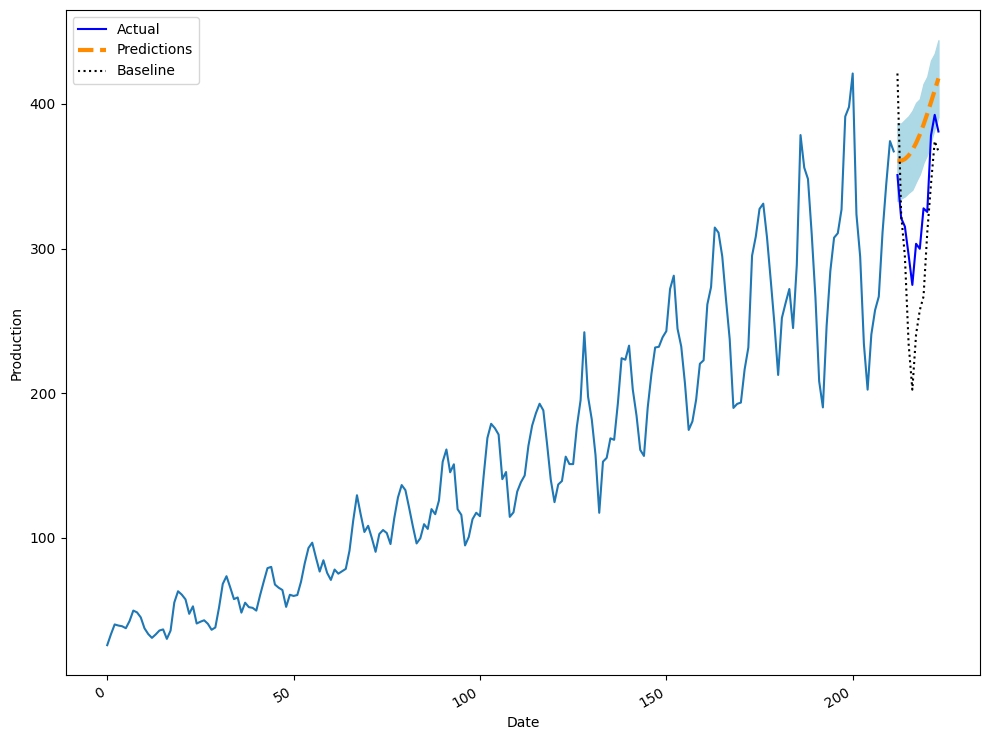

In [144]:
fig, ax = plt.subplots()
ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.set_xlabel('Date')
ax.set_ylabel('Production')
ax.legend(loc=2)

plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'],color='lightblue')

fig.autofmt_xdate()
plt.tight_layout()

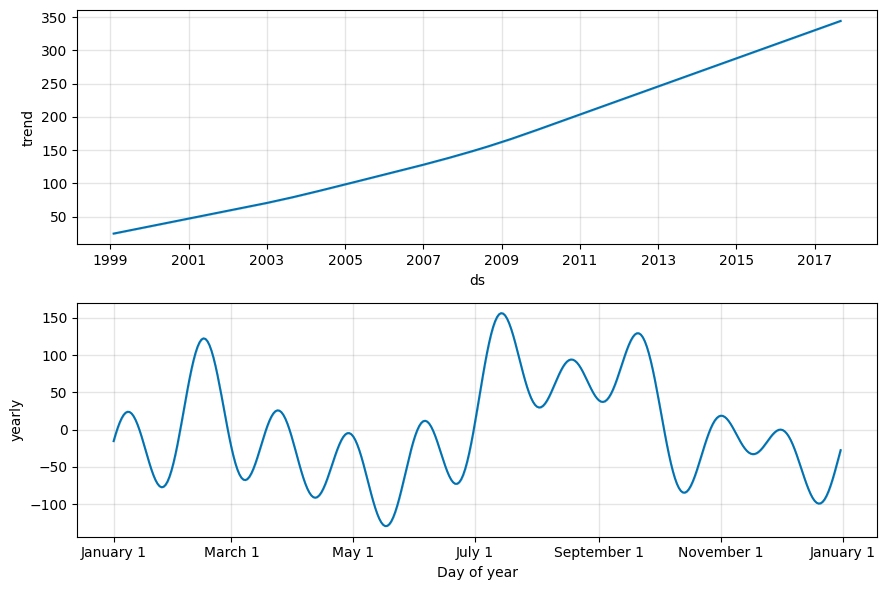

In [145]:
fig1 = model.plot_components(forecast)

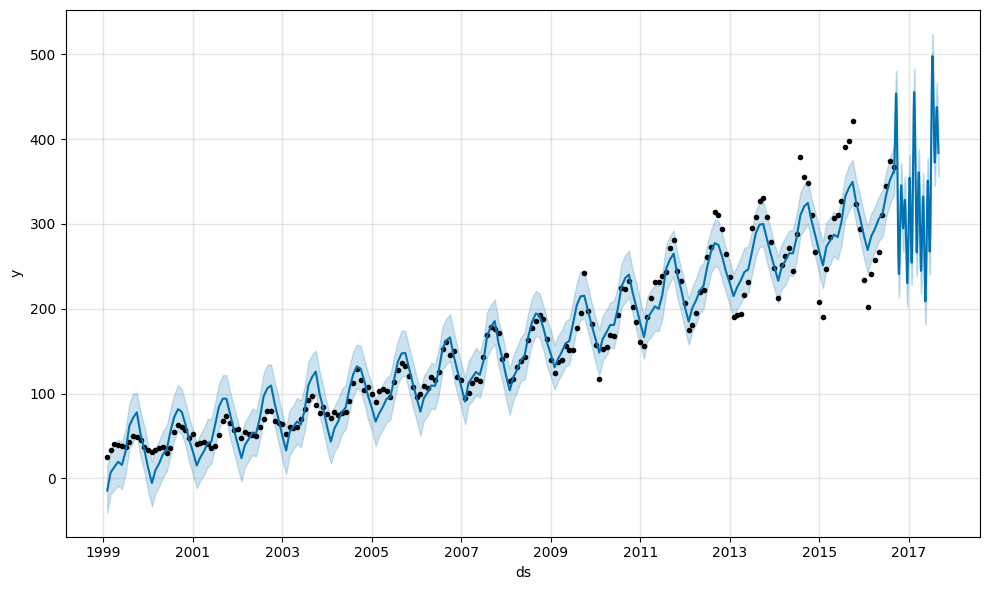

In [146]:
fig2 = model.plot(forecast)

  0%|          | 0/32 [00:00<?, ?it/s]

23:42:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:05 - cmdstanpy - INFO - Chain [1] done processing
23:43:05 - cmdstanpy - INFO - Chain [1] start processing
23:43:13 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:14 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:14 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:14 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:14 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:14 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:15 - cmdstanpy - INFO - Chain [1] done processing
23:43:15 - cmdstanpy - INFO - Chain [1] start processing
23:43:15 - cmdstanpy - INFO - Chain [1]

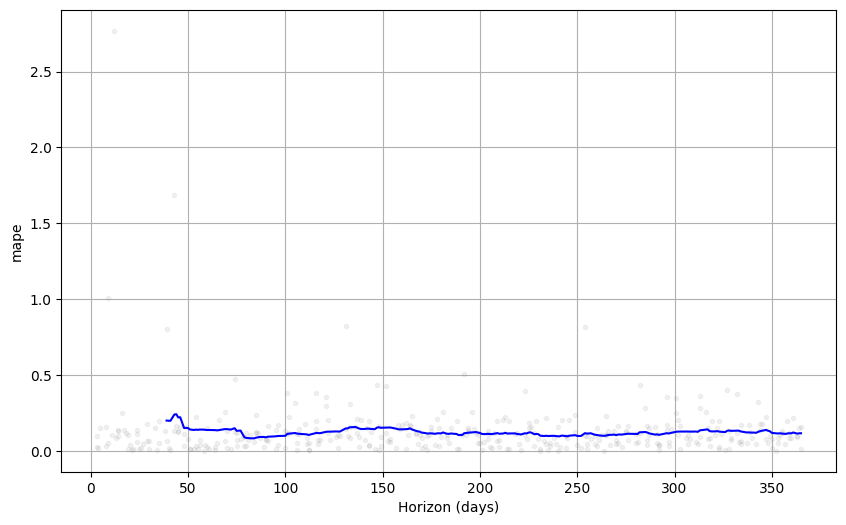

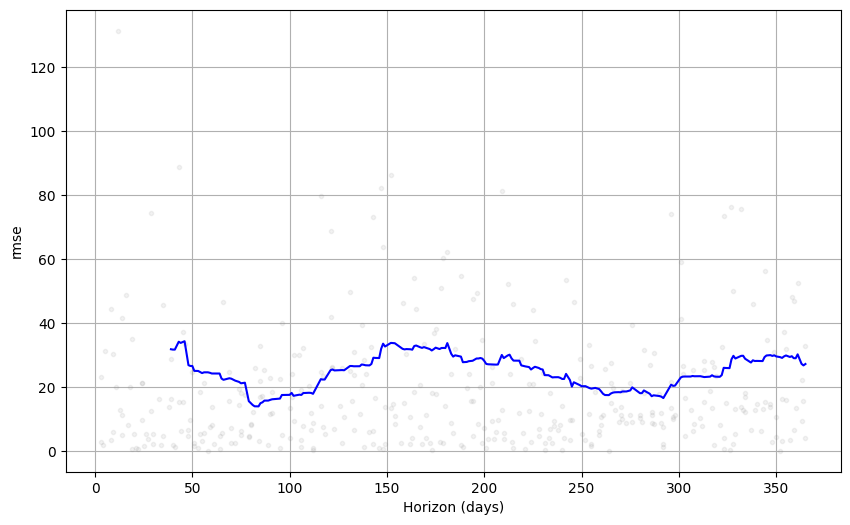

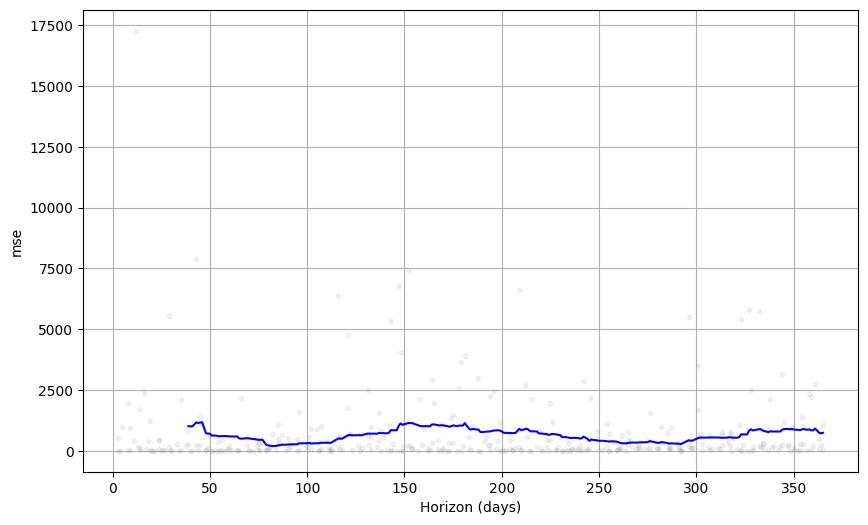

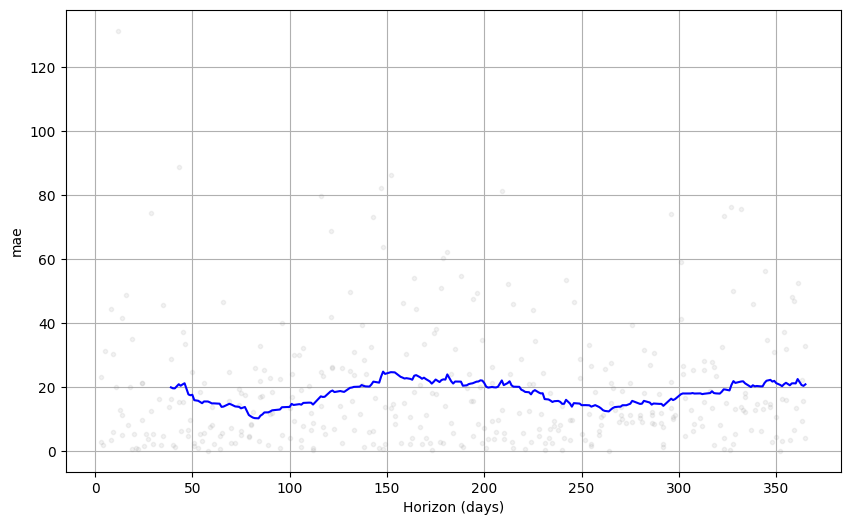

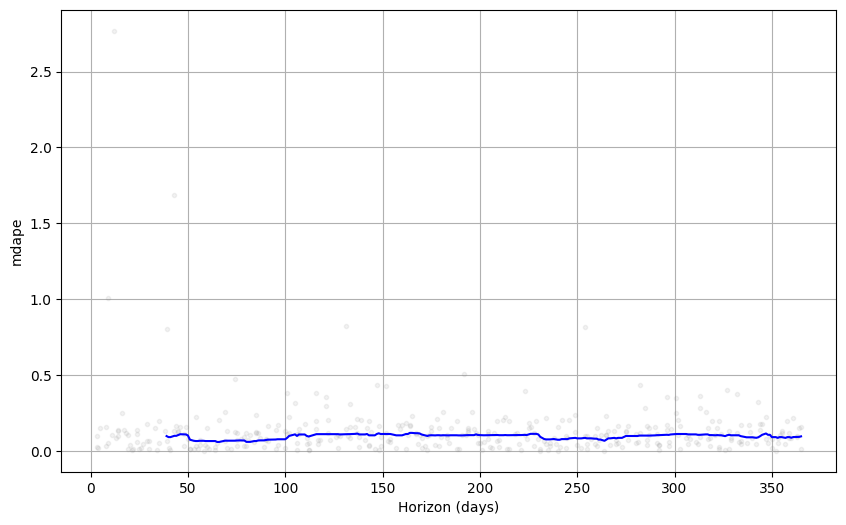

In [161]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='366 days', period='180 days', horizon = '365 days')
df_cv.head()

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig = plot_cross_validation_metric(df_cv, metric='mse')
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig = plot_cross_validation_metric(df_cv, metric='mdape')



23:41:07 - cmdstanpy - INFO - Chain [1] start processing


23:41:07 - cmdstanpy - INFO - Chain [1] done processing


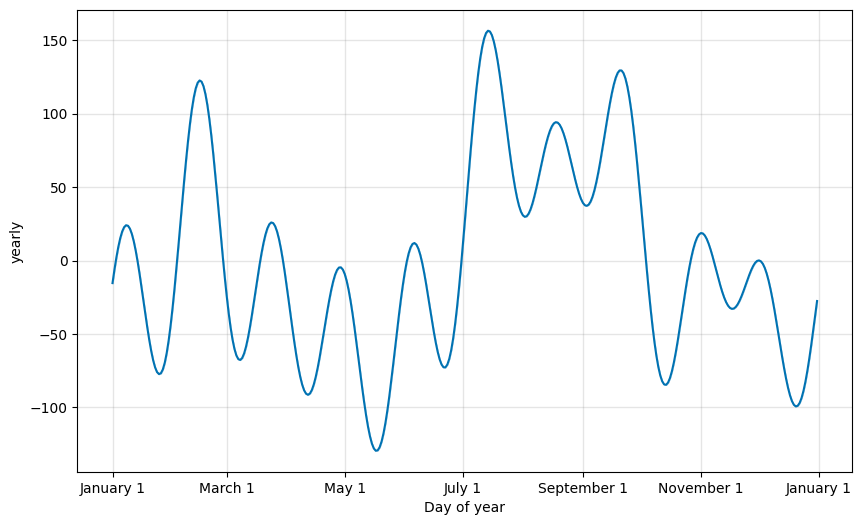

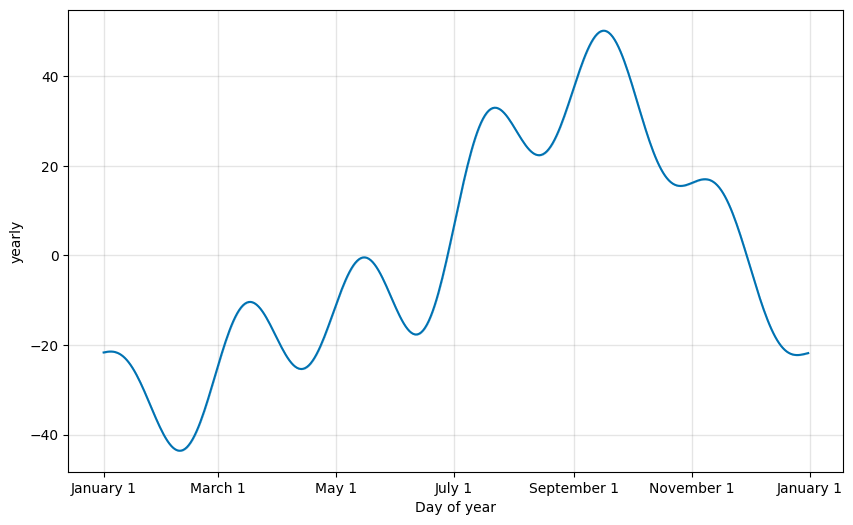

In [159]:
model2 = Prophet(yearly_seasonality=6).fit(train)
from prophet.plot import plot_yearly
fig = plot_yearly(model)
fig4 = plot_yearly(model2)


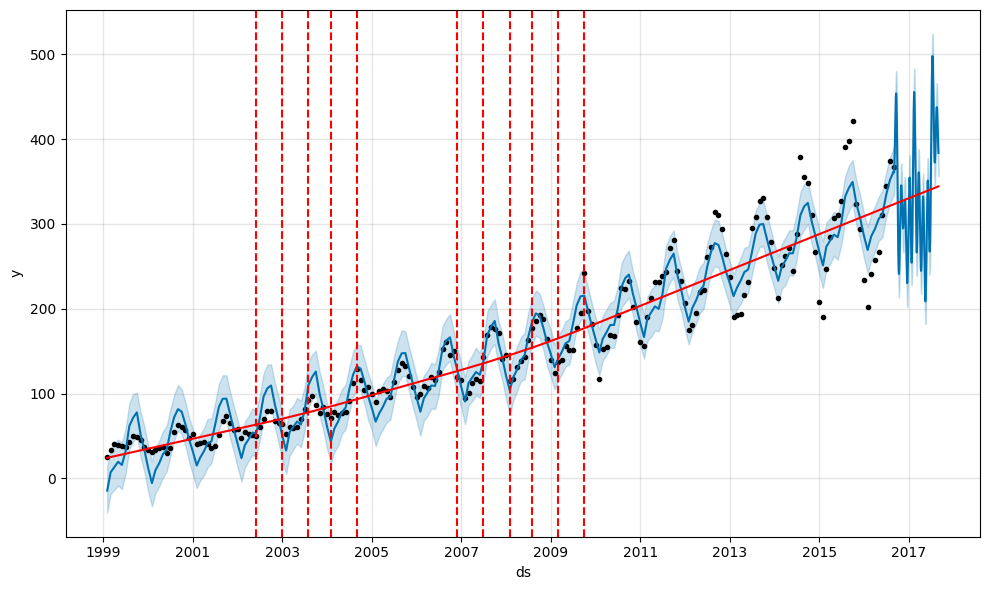

In [160]:
from prophet.plot import add_changepoints_to_plot
fig3 = model.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), model, forecast)

In [162]:
from itertools import product
param_grid = {
 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
maes = []
for params in all_params:
 m = Prophet(**params).fit(train)
 df_cv = cross_validation(m, initial='730 days', period='180 days',horizon='365 days', parallel='processes')
 df_p = performance_metrics(df_cv, rolling_window=1)
 maes.append(df_p['mae'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

23:44:32 - cmdstanpy - INFO - Chain [1] start processing
23:44:32 - cmdstanpy - INFO - Chain [1] done processing
23:44:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:44:32 - cmdstanpy - INFO - Chain [1] start processing
23:44:32 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:44:34 - cmdstanpy - INFO - Chain [1] start processing
23:44:34 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plot

In [164]:
best_params = all_params[np.argmin(maes)]
best_params

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}

### DL підходи (1dCNN, RNN, LSTM). Валідація гіперпараметрів*

In [192]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [193]:
# Load your dataset
data = pd.read_csv('df_yearly.csv')

# Convert the date_column to datetime
data['date_column'] = pd.to_datetime(data['date_column'])

# Sort the data by date
data = data.sort_values(by='date_column')

# Extract the feature(s) you want to use for prediction
# For example, if you want to predict 'Sarawak_Production', you can use:
data = data[['date_column', 'Sarawak_Production']]


In [194]:
data

,date_column,Sarawak_Production
0,1999-02-01,25.803
1,1999-03-01,33.317
2,1999-04-01,40.118
3,1999-05-01,39.372
4,1999-06-01,38.879
...,...,...
219,2017-05-01,327.777
220,2017-06-01,325.285
221,2017-07-01,378.159
222,2017-08-01,392.429


In [201]:
from keras.layers import Dense, SimpleRNN, LSTM

def fit_SimpleRNN(train_X, train_y, cell_units, epochs):

    model = Sequential() 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    return model

In [195]:

scaler = MinMaxScaler()
data['Sarawak_Production'] = scaler.fit_transform(data['Sarawak_Production'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)
sequence_length = 10
X, y = create_sequences(data['Sarawak_Production'].values, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [196]:
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [197]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
5/5 [==============================] - 1s 49ms/step - loss: 0.0832 - val_loss: 0.3186
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0593 - val_loss: 0.2379
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0406 - val_loss: 0.1700
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0253 - val_loss: 0.1146
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0156 - val_loss: 0.0678
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0098 - val_loss: 0.0360
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0241
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0233
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0263
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0315
Epoch 11/100
5/5 [=========

In [198]:
y_pred = model.predict(X_test)

# Inverse transform the scaled data to the original scale
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


2/2 [==============================] - 0s 2ms/step
Mean Squared Error: 2699.0177286471767


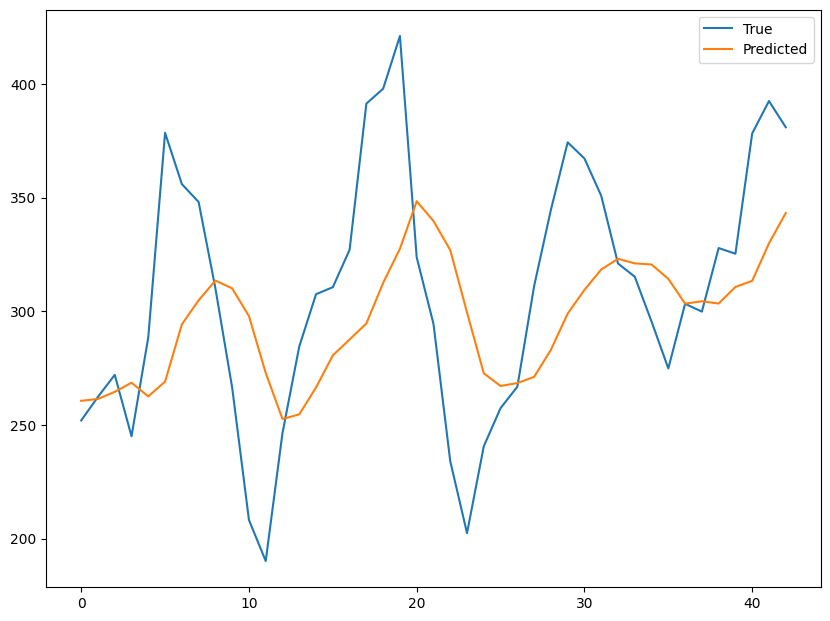

In [199]:
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [210]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(10, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [211]:
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1916
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0743
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 11/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 12/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 13/100
6/6 [==============================] - 0s 2ms/st

In [212]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [213]:
y_pred = scaler.inverse_transform(y_pred)


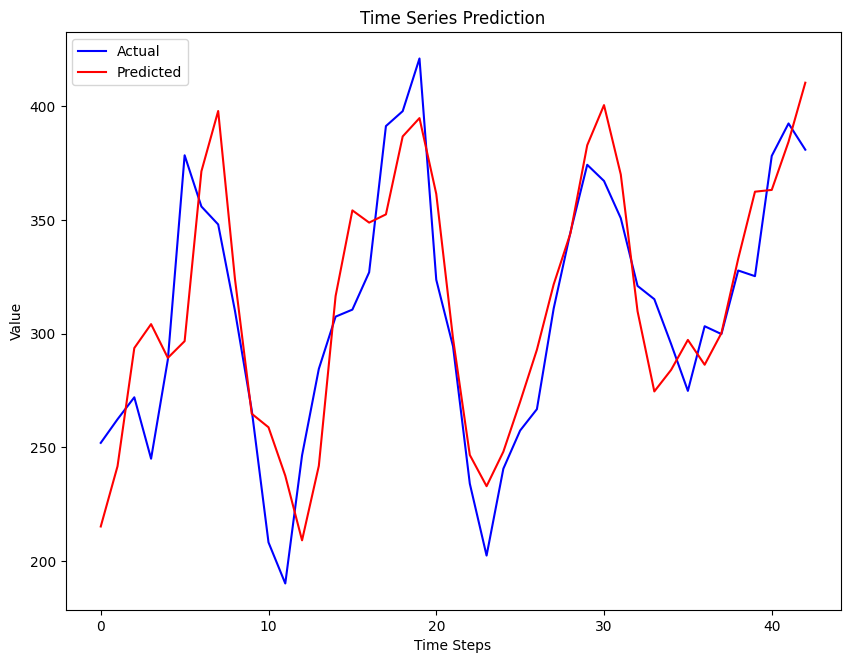

In [215]:
import matplotlib.pyplot as plt
plt.plot(y_test, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red')
plt.title("Time Series Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


In [216]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 895.3662511497064
Mean Absolute Error (MAE): 23.970249242028522
R-squared (R2) Score: 0.7132912533149599


### 1dCNN

In [219]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

data = pd.read_csv("df_yearly.csv")
X = data.drop(['Sarawak_Month', 'date_column'], axis=1).values
y = data['Sarawak_Production'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_timestamps, n_features = X_train.shape[1], 1
X_train = X_train.reshape(X_train.shape[0], n_timestamps, n_features)
X_test = X_test.reshape(X_test.shape[0], n_timestamps, n_features)


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timestamps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)
y_pred = model.predict(X_test)



Epoch 1/50
6/6 [==============================] - 0s 986us/step - loss: 37423.3320
Epoch 2/50
6/6 [==============================] - 0s 770us/step - loss: 37344.3320
Epoch 3/50
6/6 [==============================] - 0s 1ms/step - loss: 37260.6562
Epoch 4/50
6/6 [==============================] - 0s 1ms/step - loss: 37160.1484
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 37028.8008
Epoch 6/50
6/6 [==============================] - 0s 994us/step - loss: 36849.0742
Epoch 7/50
6/6 [==============================] - 0s 931us/step - loss: 36617.0312
Epoch 8/50
6/6 [==============================] - 0s 892us/step - loss: 36325.0195
Epoch 9/50
6/6 [==============================] - 0s 743us/step - loss: 35959.3281
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 35478.0977
Epoch 11/50
6/6 [==============================] - 0s 1ms/step - loss: 34914.0625
Epoch 12/50
6/6 [==============================] - 0s 1ms/step - loss: 34199.9102
Epoch 13/50
6

In [222]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error: 2715.7848955817285
Mean Squared Error (MSE): 2715.7848955817285
Mean Absolute Error (MAE): 40.094049176703564
R-squared (R2) Score: 0.689939889270021


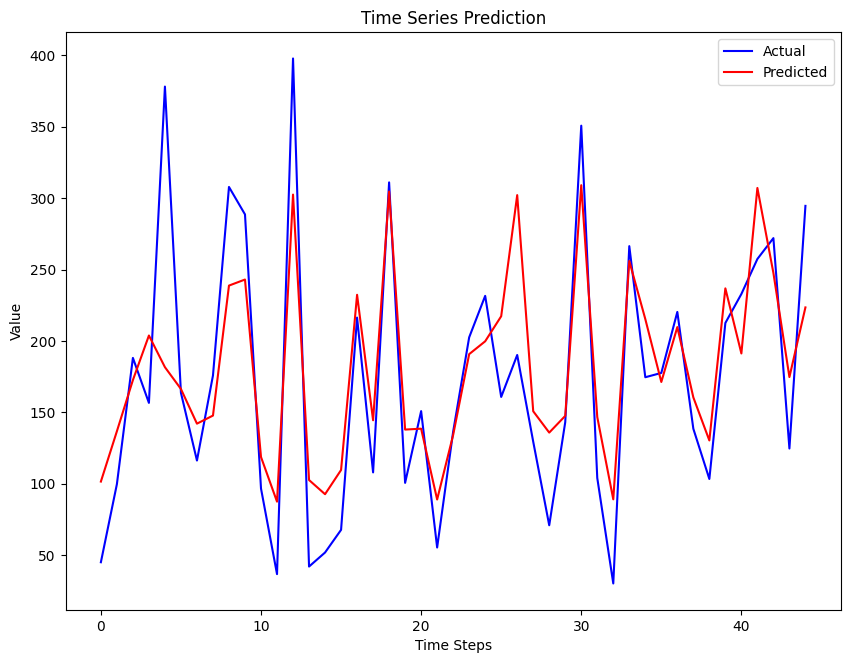

In [223]:
plt.plot(y_test, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red')
plt.title("Time Series Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

### Валідація моделей NBEATS

In [282]:
from darts import TimeSeries
data = pd.read_csv('df_yearly.csv')
df = data.copy()
series = TimeSeries.from_dataframe(data, time_col='date_column', value_cols=['Sarawak_Production'])
train, val = series.split_after(pd.Timestamp('2012-01-01'))
data.info()

split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train_df = df[:split_index]
valid_df = df[split_index:]
train_series = TimeSeries.from_dataframe(train_df, 'date_column', 'Sarawak_Production')
valid_series = TimeSeries.from_dataframe(valid_df, 'date_column', 'Sarawak_Production')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sarawak_Month        224 non-null    int64  
 1   Sarawak_Production   224 non-null    float64
 2   Sarawak_Rainfall     224 non-null    float64
 3   Sarawak_Area_ma      224 non-null    float64
 4   Sarawak_Area_npa     224 non-null    float64
 5   Sarawak_Area_rpa     224 non-null    float64
 6   Sarawak_Area_ma_new  224 non-null    float64
 7   indecies             224 non-null    int64  
 8   date_column          224 non-null    object 
dtypes: float64(6), int64(2), object(1)
memory usage: 15.9+ KB


179

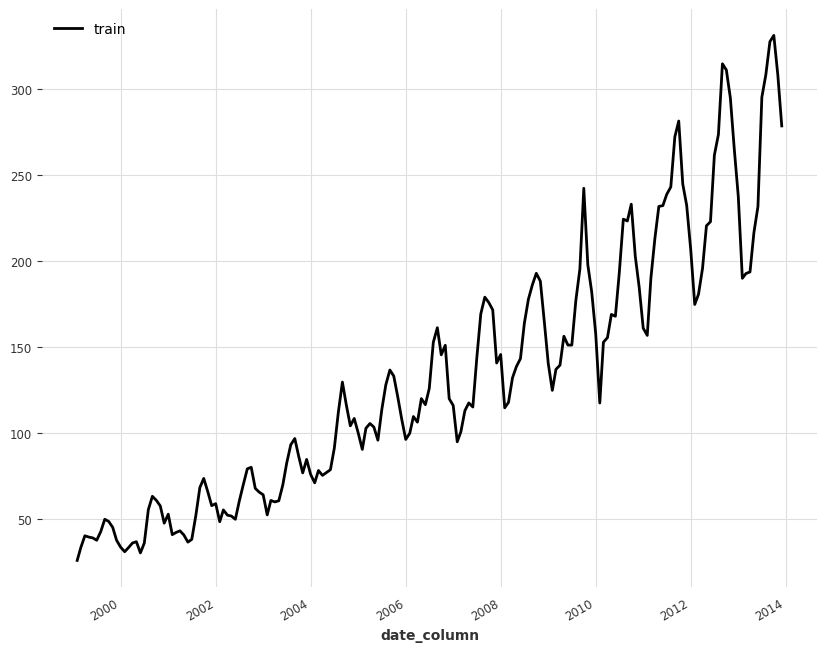

In [285]:
train_series.plot(label='train')
len(train_series)

45

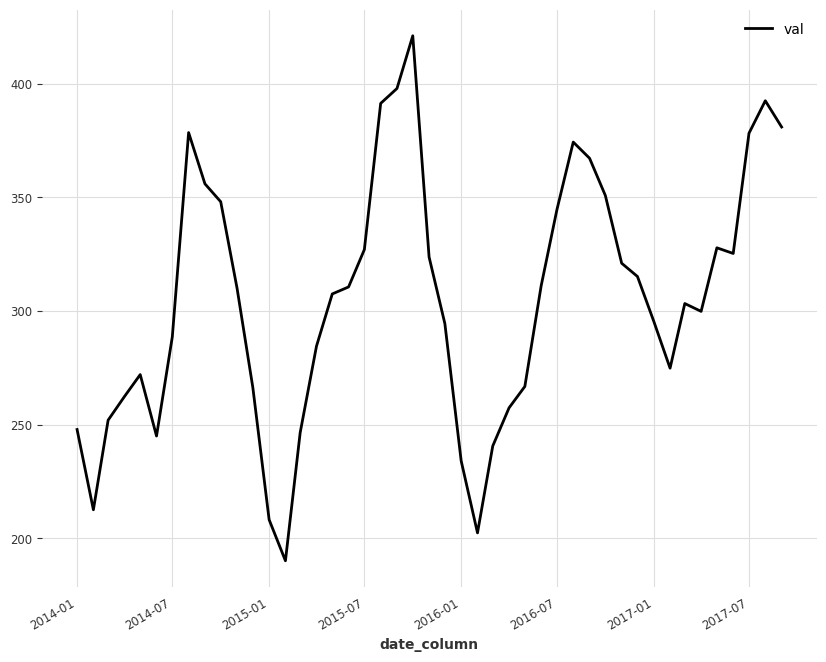

In [286]:
valid_series.plot(label='val')
len(valid_series)

In [297]:
%pip install keras-beats


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [354]:
from kerasbeats import prep_time_series, NBeatsModel
df = pd.read_csv("df_yearly.csv", parse_dates = ["date_column"], index_col = ["date_column"])
df.sort_index(inplace = True)
X, y = prep_time_series(df['Sarawak_Production'], lookback = 7, horizon = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
shuffle = False, test_size = 0.2)
nbeats = NBeatsModel(model_type = 'generic', lookback = 7, horizon = 1)
nbeats.fit(X, y, epochs = 30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 28.1970 - mae: 28.1970 - mape: 23.7516
Epoch 2/30
1/1 [==============================] - 0s 178ms/step - loss: 2325.4783 - mae: 2325.4783 - mape: 2226.8210
Epoch 3/30
1/1 [==============================] - 0s 157ms/step - loss: 699.1414 - mae: 699.1414 - mape: 646.8931
Epoch 4/30
1/1 [==============================] - 0s 175ms/step - loss: 353.7505 - mae: 353.7505 - mape: 314.5378
Epoch 5/30
1/1 [==============================] - 0s 179ms/step - loss: 96.9324 - mae: 96.9324 - mape: 89.4726
Epoch 6/30
1/1 [==============================] - 0s 173ms/step - loss: 44.5000 - mae: 44.5000 - mape: 40.1392
Epoch 7/30
1/1 [==============================] - 0s 155ms/step - loss: 55.1076 - mae: 55.1076 - mape: 50.9566
Epoch 8/30
1/1 [==============================] - 0s 173ms/step - loss: 41.6431 - mae: 41.6431 - mape: 36.7529
Epoch 9/30
1/1 [==============================] - 0s 195ms/step - loss: 95.8230 - mae: 95.8230 - mape: 

In [355]:
%pip install plotly


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [356]:
preds = pd.DataFrame(index = np.arange(len(y_train) + len(y_test)))
preds["Real Value"] = np.hstack([y_train[:, 0], y_test[:, 0]])
preds["Prediction"] = np.hstack([nbeats.predict(X_train)[:, 0], nbeats.predict(X_test)[:, 0]])
import plotly.express as px
fig = px.line(preds[["Real Value", "Prediction"]], title = "Real vs Predicted Values for N-Beats")
fig.add_vline(x = len(y_train), line_width=3, line_dash='dash', line_color='green')
fig.add_annotation(x = 140, y = 10,
 text='Training Data',
 font=dict(size=15),
 showarrow=False)
fig.add_annotation(x = 200, y = 10,
 text='Test Data',
 font=dict(size=15),
 showarrow=False)




2/2 [==============================] - 0s 21ms/step


In [357]:
preds["Real Value"]

0       49.715
1       48.463
2       45.016
3       37.468
4       33.499
        ...   
212    327.777
213    325.285
214    378.159
215    392.429
216    380.892
Name: Real Value, Length: 217, dtype: float64

In [358]:
y_test = preds["Real Value"]
y_pred = preds["Prediction"]
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error: 528.3037241643952
Mean Squared Error (MSE): 528.3037241643952
Mean Absolute Error (MAE): 16.369872571391447
R-squared (R2) Score: 0.9461618827932426


### Висновки щодо того, яку модель краще використовувати

In conclusion, a comprehensive validation of time series forecasting models was conducted, encompassing traditional SARIMA(X) models, machine learning models, deep learning approaches, and various advanced techniques. The NBEATS model emerged as the best-performing model, offering the highest accuracy as determined by the MSE test. 